In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# open hdf5
path = "../DATA/contribution_22_full.hdf5"
ds = xr.open_dataset(path)
ds

<xarray.Dataset> Size: 329MB
Dimensions:                 (wavelength: 52, sample: 91392, parameter: 6,
                             quartile: 3, species: 5)
Coordinates:
  * wavelength              (wavelength) float64 416B 0.55 0.7 ... 6.814 7.276
  * sample                  (sample) int64 731kB 0 1 2 3 ... 91389 91390 91391
  * parameter               (parameter) <U13 312B 'planet_temp_k' ... 'log_NH3'
  * quartile                (quartile) <U2 24B 'q1' 'q2' 'q3'
  * species                 (species) <U3 60B 'H2O' 'CO2' 'CH4' 'CO' 'NH3'
Data variables: (12/22)
    bin_width               (wavelength) float64 416B ...
    spectrum                (sample, wavelength) float64 38MB ...
    noise                   (sample, wavelength) float64 38MB ...
    planet_temp_k           (sample) float64 731kB ...
    log_H2O                 (sample) float64 731kB ...
    log_CO2                 (sample) float64 731kB ...
    ...                      ...
    planet_radius_m         (sample) float64 731kB ...
    planet_surface_gravity  (sample) float64 731kB ...
    valid_quartiles         (sample) bool 91kB ...
    parameter_quartiles     (sample, parameter, quartile) float64 13MB ...
    contributions           (sample, species, wavelength) float64 190MB ...
    clean_forward_model     (sample, wavelength) float64 38MB ...

In [3]:
ipath = "../SpeciesRetrieval/train_validation_indecies.hdf5"
ids = xr.open_dataset(ipath)
ids

<xarray.Dataset> Size: 731kB
Dimensions:    (train_samples: 73113, val_samples: 18279)
Dimensions without coordinates: train_samples, val_samples
Data variables:
    train_idx  (train_samples) int64 585kB ...
    val_idx    (val_samples) int64 146kB ...

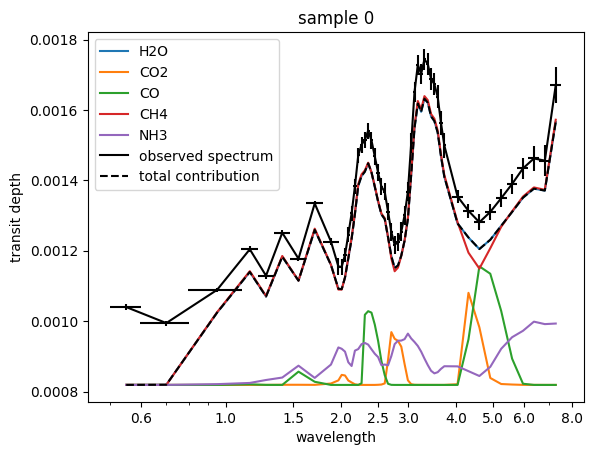

In [4]:
i = 0
all_species = ds.species.values[1:]

plt.plot(
    ds['wavelength'],
ds['contributions'].sel(sample=i,
                    species=['H2O', 'CO2', 'CO', 'CH4', 'NH3']
                    ).values.T, label=['H2O', 'CO2', 'CO', 'CH4', 'NH3'])

plt.plot(ds['wavelength'],ds['spectrum'].sel(sample=i).values, "k-", label='observed spectrum')

plt.errorbar(ds['wavelength'],ds['spectrum'].sel(sample=i).values,xerr=ds['bin_width']/2, yerr=ds['noise'].sel(sample=i).values, fmt='none', color='black', )

plt.plot(ds['wavelength'],ds['contributions'].sel(sample=i).isel(species = 0).values, "k--", label='total contribution')

plt.xlabel('wavelength')
plt.ylabel('transit depth')

axs = plt.gca()
axs.set_xscale('log')
axs.set_xticks([0.6, 1,1.5, 2, 2.5,3,4, 5, 6,8,])
axs.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.title(f'sample {i}')
plt.legend()

In [5]:
label_names = ['log_H2O']
labels = ds[label_names]
labels_np = labels.to_array().values.T

labels_np.shape

(91392, 1)

In [6]:
spectrum_np = ds['spectrum'].values
spectrum_np.shape

(91392, 52)

In [7]:
noise_np = ds['noise'].values
noise_np.shape

(91392, 52)

In [8]:
train_spectra = spectrum_np[ids['train_idx']]
train_labels = labels_np[ids['train_idx']]
train_noise = noise_np[ids['train_idx']]
train_spectra.shape, train_labels.shape, train_noise.shape

((73113, 52), (73113, 1), (73113, 52))

In [9]:
# validation_spectra = spectrum_np[ids['val_idx']]
# validation_labels = labels_np[ids['val_idx']]
# validation_noise = noise_np[ids['val_idx']]
# validation_spectra.shape, validation_labels.shape, validation_noise.shape

In [10]:
# split train into train and test
train_spectra, test_spectra, train_labels, test_labels, train_noise, test_noise = train_test_split(train_spectra, train_labels, train_noise, test_size=0.2, random_state=42)

# print shapes in table
print(f"""
train_spectra: {train_spectra.shape}
train_labels: {train_labels.shape}
train_noise: {train_noise.shape}

test_spectra: {test_spectra.shape}
test_labels: {test_labels.shape}
test_noise: {test_noise.shape}
""")


train_spectra: (58490, 52)
train_labels: (58490, 1)
train_noise: (58490, 52)

test_spectra: (14623, 52)
test_labels: (14623, 1)
test_noise: (14623, 52)



In [11]:
# create a model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(52, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [13]:
model = Net()

# create a loss function
criterion = nn.MSELoss()

# create an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# create a data loader
batch_size = 128
train_dataset = TensorDataset(torch.Tensor(train_spectra), torch.Tensor(train_labels))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [14]:
def plot_loss(losses, epoch):

    losses = np.array(losses)

    plt.figure()
    plt.plot(losses, "k-")

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'training loss\nepoch: {epoch}')

    plt.yscale('log')

    plt.ylim(losses.mean() - 3 * losses.std(), 4)

    plt.savefig('training_loss.png')
    plt.close()

In [15]:
def plot_predictions(predictions, labels, epoch):
    # make sure plot is square
    plt.figure(figsize=(5, 5))
    plt.plot(labels, predictions, "k.", label='predictions')
    plt.plot(labels, labels, "r--", label='Ground Truth')
    plt.xlabel('true log H2O value')
    plt.ylabel('predicted H2O value')
    plt.title(f'predictions\nepoch: {epoch}')

    plt.xlim(labels.min(), labels.max())
    plt.ylim(labels.min(), labels.max())

    plt.savefig('predictions.png')
    plt.close()

In [16]:
batch_losses = []
epoch_losses = []


# train the model
model.train()
for epoch in range(1000):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())



    epoch_losses.append(np.mean(batch_losses))
    batch_losses = []

    if epoch % 5 == 0:
        # print(f'epoch {epoch}, loss {epoch_losses[-1]}')
        plot_loss(epoch_losses, epoch)
        plot_predictions(outputs.detach().numpy(), labels.detach().numpy(), epoch)

/var/folders/zh/qc7vldz11_b9qr83pcdjjpk40000gn/T/ipykernel_69647/4264383715.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(losses.mean() - 3 * losses.std(), 4)


KeyboardInterrupt: 